# Load data from [Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/)


In [1]:
%matplotlib inline

# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage,misc
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import h5py
import math

## Download data

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('train.tar.gz', 404141560)
test_filename = maybe_download('test.tar.gz', 276555967)

Found and verified train.tar.gz
Found and verified test.tar.gz


## Extract data

In [3]:
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  nb_files = len([
    file_name for file_name in sorted(os.listdir(root))
    if file_name.endswith(".png")])
  print("found %d image files in %s" % (nb_files,root))
  return root
  
train_folder = maybe_extract(train_filename)
test_folder = maybe_extract(test_filename)

train already present - Skipping extraction of train.tar.gz.
found 33402 image files in train
test already present - Skipping extraction of test.tar.gz.
found 13068 image files in test


## Display some images

displaying 2 sample images from folder train
6713.png


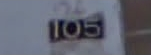

25667.png


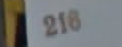

displaying 2 sample images from folder test
5312.png


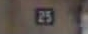

11708.png


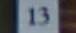

In [ ]:
def display_sample_images(folder,to_display=5):
    print("displaying %d sample images from folder %s" %(to_display,folder))
    images=[file_name for file_name in sorted(os.listdir(folder)) 
            if file_name.endswith(".png")]
    for image in np.random.choice(images,to_display):
        print(image)
        display(Image(os.path.join(folder, image)))

display_sample_images(train_folder,2)
display_sample_images(test_folder,2)

## Load the data in a more manageable format

In [ ]:
pixel_depth = 255.0  # Number of levels per pixel.
image_size = 64  # Pixel width and height.
sub_image_size=54

final_image_size=32

def display_image(image):
    plt.figure()
    plt.imshow(image)
    plt.show()

def expand(min_,max_,ratio,maximum):
    dist=math.ceil((max_-min_)*ratio)
    min_=int(min_-dist)
    max_=int(max_+dist)
    return max(min_,0),min(max_,maximum)

def load_folder(folder, min_num_images,to_add=0,max_num_images=None):
    """Load the data for a folder."""
    dataset= {}
    dataset['height'] = []
    dataset['label'] = []
    dataset['left'] = []
    dataset['top'] = []
    dataset['width'] = []
    dataset['image'] = []
    
    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(f[obj[k][0]][0][0])
        dataset[name].append(vals)
    
    image_files = sorted([file_name for file_name in os.listdir(folder)
                if file_name.endswith(".png")],
                         key=lambda name:int(name[:-4]))
    print ('first_images :')
    print(image_files[:10])
    total_images=len(image_files)
    image_index=-1
    num_images=0
    digitStruct_file = os.path.join(folder, "digitStruct.mat")
    with h5py.File(digitStruct_file,"r") as f:
        for item in f['/digitStruct/bbox']:
            image_index = image_index+1
            image_file = os.path.join(folder, image_files[image_index])
            try:
                image_data = (ndimage.imread(image_file).astype(float) - 
                              pixel_depth / 2) / pixel_depth
                dataset["image"].append(image_data)
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
                continue
            f[item[0]].visititems(print_attrs)
            num_images=num_images+1
            if image_index % 500 == 0:
                percent=image_index*100/total_images
                sys.stdout.write("%d%%" % percent)
                sys.stdout.flush()
            elif image_index % 50 == 0:
                sys.stdout.write(".")
                sys.stdout.flush()
            if max_num_images!=None and num_images>=max_num_images:
                break
    
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))
    
    print('loaded %d images'% len(dataset["image"]))
    print("resizing, reshaping and multiplying images")
    image_index=0
    heights = []
    labels = []
    lefts = []
    tops = []
    widths = []
    images = []
    
    def resize_and_add_image(height,label,left,top,width,image):
        resized= misc.imresize(image,(image_size, image_size))
        #TODO also resize the heights,widths,lefts and tops
        heights.append(height)
        labels.append(label)
        lefts.append(left)
        tops.append(top)
        widths.append(width)
        images.append(resized)
        
    for height,label,left,top,width,image in zip(
        dataset['height'],dataset['label'],dataset['left'],dataset['top'],dataset['width'],dataset['image']):
        resize_and_add_image(height,label,left,top,width,image)
        if to_add > 0:
            #print("original image")
            #display_image(image)
            #find out the minimum rectangle containing the digits            
            min_left=image.shape[1]
            min_top=image.shape[0]
            max_right=0
            max_bottom=0
            #print("initial ",min_top,max_bottom,min_left,max_right)
            for i in range(len(label)):
                min_left=min_left if min_left<=left[i] else left[i]
                min_top=min_top if min_top<=top[i] else top[i]
                right=left[i]+width[i]
                max_right=max_right if max_right>=right else right
                bottom=top[i]+height[i]
                max_bottom=max_bottom if max_bottom >= bottom else bottom
                
            #print("before expanding ",min_top,max_bottom,min_left,max_right)
            
            #expand the bounding box by 30%
            ratio=.30
            min_left,max_right=expand(min_left,max_right,ratio,image.shape[1])
            min_top,max_bottom=expand(min_top,max_bottom,ratio,image.shape[0])
            croped_image=image[min_top:max_bottom,min_left:max_right,:]            
            #print("cropped by ",min_top,max_bottom,min_left,max_right)
            #display_image(croped_image)
            resized_crop=misc.imresize(croped_image,(image_size, image_size))
            size_diff=image_size-sub_image_size
            new_tops=np.random.choice(size_diff,to_add,replace=False)
            new_lefts=np.random.choice(size_diff,to_add,replace=False)
            for new_top,new_left in zip(new_tops,new_lefts):
                new_image=resized_crop[new_top:new_top+sub_image_size,new_left:new_left+sub_image_size,:]  
                #print("new image ")
                #display_image(new_image)
                #TODO also ajust the heights,widths,lefts and tops information
                resize_and_add_image(height,label,left,top,width,new_image)
        
        if image_index % 500 == 0:
            percent=image_index*100/num_images
            sys.stdout.write("%d%%" % percent)
            sys.stdout.flush()
        elif image_index % 50 == 0:
            sys.stdout.write(".")
            sys.stdout.flush()
        image_index+=1
    dataset['height'] = heights
    dataset['label'] = labels
    dataset['left'] = lefts
    dataset['top'] = tops
    dataset['width'] = widths
    dataset['image'] = images
    
    print("resized to %d: "%len(images))
    return dataset
        
def maybe_pickle(folder, min_num_images_per_class, force=False,to_add=0,max_num_images=None):
    set_filename = folder + '.pickle'
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
        print('Pickling %s.' % set_filename)
        dataset = load_folder(folder, min_num_images_per_class,to_add=to_add,max_num_images=max_num_images)
        try:
            with open(set_filename, 'wb') as f:
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', set_filename, ':', e)
    return set_filename

train_datasets = maybe_pickle(train_folder, 32000,to_add=7) #add seven new images for each train image
test_datasets = maybe_pickle(test_folder, 12000)


Pickling train.pickle.
first_images :
['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png']
0%.........1%.........2%.........4%....

In [ ]:
min(1,0)

## Display some labels and images to make sure that everything is loaded fine 

In [ ]:
def display_images(file_name,num_images=5):
    print ("showing some labels and images for %s"%file_name)
    with open(file_name, 'r') as f:
        data=pickle.load(f)
        labels=data["label"]
        total_images=len(labels)
        images=data["image"]
        print("loaded %d images"%total_images)
        for i in np.random.choice(total_images,num_images,):
            for j in range(i,i+5):
                print(labels[j])
                display_image(images[j])
            
display_images(train_datasets)
display_images(test_datasets)

# Generate train data